# AnomalyToolKit: Typicality check - Batch application

This text explains how to use the production checks in the AnomalyToolKit for batch mode and offline use. 

# Loading modules

Loading the modules we need throughout the notebook and fine-tuning the browser display:

In [1]:
import numpy 
import pandas
import os
import sys
import time
import matplotlib.pyplot as plt
from pathlib import Path

sys.path.append('..')

# Loading data

As an example, we use data from a sensor ageing data repository.  (v1.0.2) [[Zenodo]](https://doi.org/10.5281/zenodo.3229195). Make sure you have downloaded the file  `potential_rowB.zip`, unzip the contents into a folder of your liking. Then, make sure the folder path in the following cell matches the folder you have chosen:

In [2]:
strFolder = 'C:/G/data/sensorageing/potential_rowB/'

To enable use of the productivity check, we load all data in a string format. This avoids automatic conversions which may mask some issues with the data.

In [3]:
filename  = Path(strFolder+'rowB_potential_day332.csv')
dfStrData = pandas.read_csv(filepath_or_buffer=filename,delimiter  =';',header =0,dtype=str)
dfStrData.head()

date_time         T1b         T2b         T3b         T4b  \
0  2017.08.31 00:00:01   30.400000    2.700000   -9.300000   48.599998   
1  2017.08.31 00:00:02   30.300001    2.700000   -9.300000   48.599998   
2  2017.08.31 00:00:03   30.400000    2.600000   -9.400000   48.599998   
3  2017.08.31 00:00:04   30.400000    2.700000   -9.400000   48.599998   
4  2017.08.31 00:00:05   30.300001    2.700000   -9.300000   48.599998   

  Unnamed: 5  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN

# DateTimeCheck + NumericCheck + TypicalityCheck: Setup and testing

We set up an one instance of the class *datetimecheck* in the *production* module and call it *dtcheck*. We define it so that the expected datetime format matches the *date_time* variable in the first 5 lines shown above. We also set up a check to test if the sensor readings can be interpreted as numeric values. The checks are instances of the class *numericcheck* in the same module (*production*). Finally, we add a *typicalitycheck* from the *typical* module and called *typcheck*. This check evaluate the degree to which the numeric value is typical relative to the historical data To do this, we require the specification of the accepted measurement range, we set it here to +/- 420 mV. In this case, this roughly corresponds to (theoretical) pH values from 0 to 14.

In [4]:
from basic.production import datetimecheck
from basic.typical import typicalitycheck
from basic.production import numericcheck

CheckDT  = datetimecheck(DateTimeFormat='%Y.%m.%d %H:%M:%S')
CheckNUM = numericcheck(NumberFormat='float')
CheckTYP = typicalitycheck(MinimumFeasibleValue=-420,MaximumFeasibleValue=+420)

## DateTimeCheck + NumericCheck + TypicalityCheck: Batch mode application

### Batch mode application

The syntax for to use the `typicalitycheck` check in offline mode is practically the same as for the online mode. We can simply apply the check to the signal values produced by the `numericcheck`. We are also checking how much time we need to execute the checks for a single day of data:

In [5]:
start_time = time.time()
CheckResult , DateTime =  CheckDT(DateTimeEntry=dfStrData['date_time'])
print("--- %s seconds ---" % (time.time() - start_time))

--- 4.242053031921387 seconds ---


In [6]:
start_time = time.time()
CheckResult , Number = CheckNUM(NumberEntry=dfStrData['T4b'])
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.3960540294647217 seconds ---


In [7]:
start_time = time.time()
Score, Density = CheckTYP(Number,Mode='Batch')
print("--- %s seconds ---" % (time.time() - start_time))

--- 10.77065396308899 seconds ---


As one can see, checking the typicality is computationally more expensive. However, typical execution time is still under 1 minute for a time window of 1 day. 

A slightly different application is to process the data only to build the density model, without evaluating the typicality score. This will be useful below to train the density model first on many data sets, only to apply after training is finished:

In [8]:
start_time = time.time()
CheckTYP(Number,Mode='Train')
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.009023666381835938 seconds ---


Note how this training is executed very efficiently.

**Visualization**

The next graph has two panels. The top panel shows the sensor readings as a function of the sample index with a colour indicating the typicality score. The bottom panel show this typicality score, also as a function of the sample index, with the same colouring.

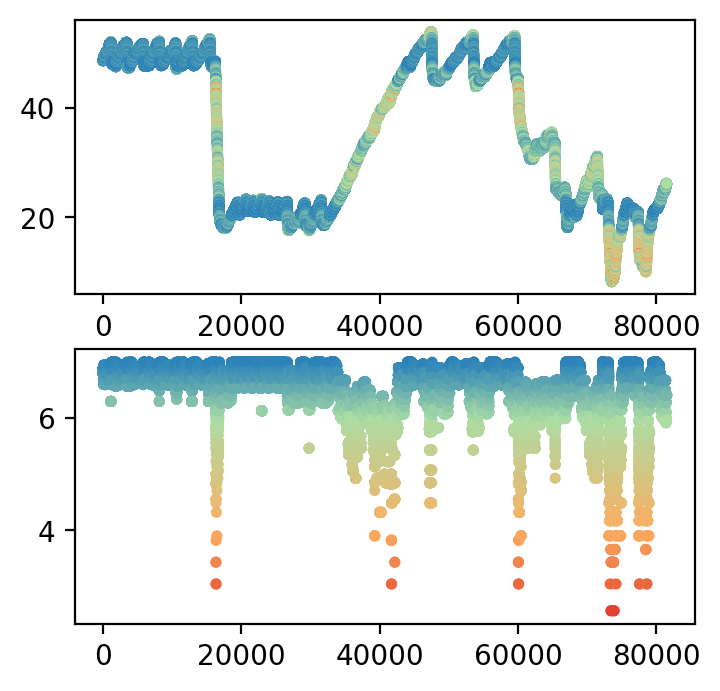

In [9]:
NumberOfSamples = len(Score)
x = numpy.arange(NumberOfSamples);
y = Number;
z = Score;

from basic.visual import mapsequential
cmap = mapsequential()

hFig,hAx = plt.subplots(2,1, figsize=(4,4),dpi=200)
hScat00 = hAx[0].scatter(x=x,\
                         y=y,\
                         c=z,\
                         cmap=cmap,\
                         marker='.',linestyle='None', vmin=0, vmax=7)

hScat10 = hAx[1].scatter(x=x,\
                         y=z,\
                         c=z,\
                         cmap=cmap,\
                         marker='.',linestyle='None', vmin=0, vmax=7)

### Sequencing batch mode application

In the above, we applied the test to the data from a single day (day 332). We will now apply the test for the first 11 days. For this, we will apply a for loop that sequentially processes the data from a single day, starting at day 1 and ending with day 11.

**Note on efficiency**

For a large data set, we may want to apply the check to all data. Loading the complete data set is not recommended however. In general, there is some trade-off between loading larger chunks of data in memory, which minimizes the number of times data needs to be loaded and the check needs to be executed, and loading smaller chuncks of data in memory, which minimizes the memory usage. The optimal trade-off depends on several factors. This includes factors concering your computer system as well as factors related to the way you obtain your data (e.g., the responsiveness of a database query). Here, we will assume that the data is separated optimally in the provided data files. Each file has the data of one day and we assume that this is the optimal size of a chunk of data.

#### Sequencing batch training

For batch-mode application we loop over the data twice. In the first loop, we simply process all data points to produce a density model:

In [10]:
nDay = 11

for day in range(nDay):
    filename = 'rowB_potential_day'+str(numpy.char.zfill(str(day+1),3))+'.csv'
    filepath = Path(strFolder+filename)
    if os.path.isfile(filepath):
        print(filename)
        dfStrData =pandas.read_csv(filepath_or_buffer=filepath,delimiter  =';',header =0,dtype=str)
        CheckResult0 , DateTime =  CheckDT(DateTimeEntry=dfStrData['date_time'])
        CheckResult1 , Number   = CheckNUM(NumberEntry=dfStrData['T4b'])
        
        CheckTYP(Number,Mode='Train')
        

rowB_potential_day001.csv
rowB_potential_day002.csv
rowB_potential_day003.csv
rowB_potential_day004.csv
rowB_potential_day005.csv
rowB_potential_day006.csv
rowB_potential_day007.csv
rowB_potential_day008.csv
rowB_potential_day009.csv
rowB_potential_day010.csv
rowB_potential_day011.csv


The next graph shows the density model after training:

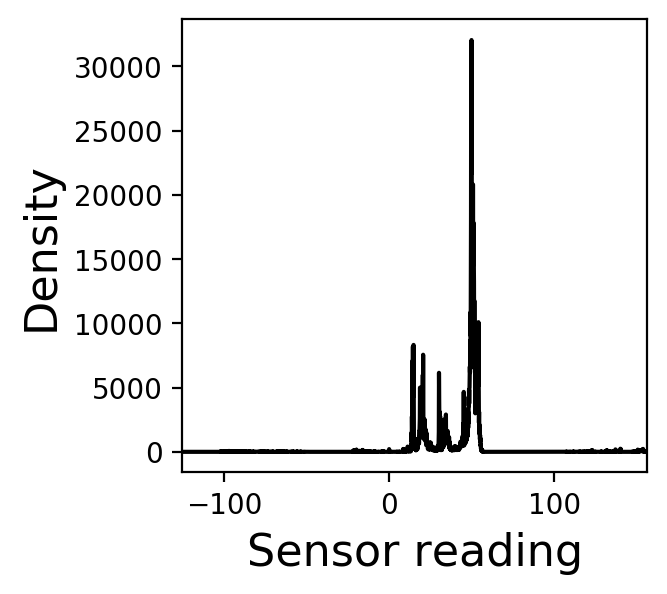

In [11]:
x = CheckTYP.rValue;
y = CheckTYP.rWeight;

fig = plt.figure(figsize=(3,3),dpi=200)
plt.plot(x,y,color='k')
ax = fig.gca()
ax.set_xlabel('Sensor reading', fontsize=16)
ax.set_ylabel('Density', fontsize=16)
ax.set_xlim([CheckTYP.rMinObs,CheckTYP.rMaxObs])
plt.show()

In the second loop, we now apply the calibrated density model to every data point. As before, this is done with an out-of-bag approach. This means every sample is subtracted from the density model before applying the model. Note the changed syntax: 

`Score, Density = CheckTYP(Number,Mode='Batch',NewSample=False)`.

In [12]:
x = numpy.empty((0,), dtype=[('DateTime', numpy.datetime64),\
                             ('DateTimeCheck', numpy.datetime64),\
                             ('Number', numpy.datetime64),\
                             ('Score',numpy.float_),\
                             ('Density',numpy.float_)])
dfTypical = pandas.DataFrame(x)

for day in range(nDay):
    filename = 'rowB_potential_day'+str(numpy.char.zfill(str(day+1),3))+'.csv'
    filepath = Path(strFolder+filename)
    if os.path.isfile(filepath):
        print(filename)
        dfStrData =pandas.read_csv(filepath_or_buffer=filepath,delimiter  =';',header =0,dtype=str)
        CheckResult0 , DateTime =  CheckDT(DateTimeEntry=dfStrData['date_time'])
        CheckResult1 , Number   = CheckNUM(NumberEntry=dfStrData['T4b'])
        
        Score, Density = CheckTYP(Number,Mode='Batch',NewSample=False)
    
        dfADD = pandas.DataFrame(columns=['DateTime','DateTimeCheck','Number','Score','Density'])
        dfADD['DateTime'] = DateTime
        dfADD['DateTimeCheck'] = CheckResult0
        dfADD['Number'] = Number
        dfADD['Score'] = Score
        dfADD['Density'] = Density
        
        dfTypical = pandas.concat([dfTypical, dfADD],ignore_index=True,sort=False)
        
print('DONE')

rowB_potential_day001.csv
rowB_potential_day002.csv
rowB_potential_day003.csv
rowB_potential_day004.csv
rowB_potential_day005.csv
rowB_potential_day006.csv
rowB_potential_day007.csv
rowB_potential_day008.csv
rowB_potential_day009.csv
rowB_potential_day010.csv
rowB_potential_day011.csv
DONE


We now produce the same figure as above, however now covering 11 days of data:

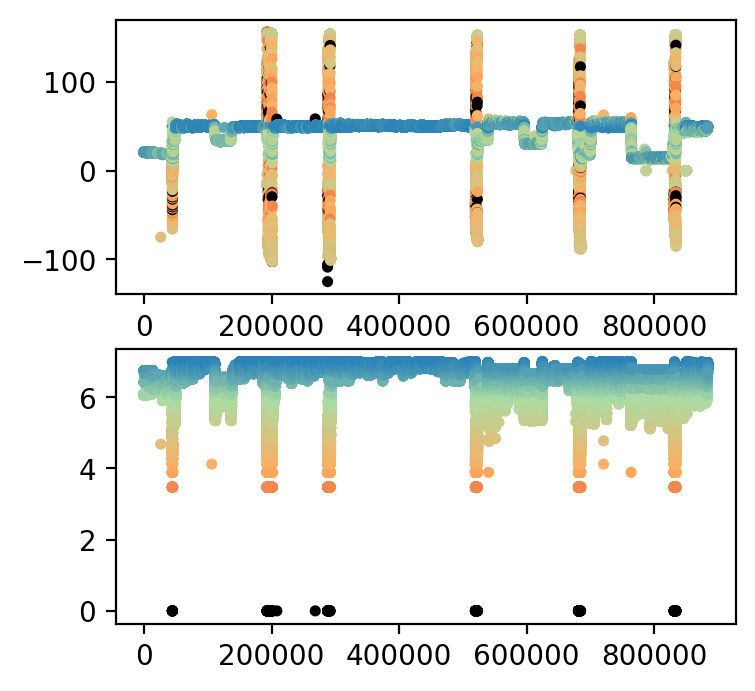

In [13]:
NumberOfSamples = len(dfTypical)
x = numpy.arange(NumberOfSamples);
y = dfTypical['Number'];
z = dfTypical['Score'];

from basic.visual import mapsequential
cmap = mapsequential()

hFig,hAx = plt.subplots(2,1, figsize=(4,4),dpi=200)
hScat00 = hAx[0].scatter(x=x,\
                         y=y,\
                         c=z,\
                         cmap=cmap,\
                         marker='.',linestyle='None', vmin=0, vmax=7)
hScat10 = hAx[1].scatter(x=x,\
                         y=z,\
                         c=z,\
                         cmap=cmap,\
                         marker='.',linestyle='None', vmin=0, vmax=7)

# TypicalityCheck: Aggregation

The *aggregator* feature computes a number of summary statistics, including the minimum, mean, and maximum value for consecutive time windows. The time window is specified as an integer number of hours, which has to be a divisor of 24 (permitted values: 1, 2, 3, 4, 6, 8, 12, 24, default: 24). The next piece of code specifies aggregation in periods of 3 hours.

In [14]:
from basic.typical import aggregate

TimeWindow = 3 ;
agg1 = aggregate(TimeWindow=TimeWindow,NumberOfSample=3600*TimeWindow)

The *aggregate* feature requires the use of a pandas dataframe and requires that this dataframe contains:

* A column named `DateTime` which contains the datetime (pandas timestamp)

* A column named `DateTimeCheck` which contains the datetime check result (boolean)

* A column named `Score` which contains the typicality score

This dataframe is passed in by calling the instance of *aggregate*, which then computes the summary statistics:

In [15]:
SummaryStats = agg1(dfTypical)

In order to enable easy updating of these counts (see example below), the obtained statistics are also memorized internally:

In [16]:
print(agg1.summarystats)

                    ScoreMin ScoreMax ScoreMean
Date       TimeSlot                            
2016-10-04 0         6.05716  6.74708   6.64184
           1         6.09402  6.74708   6.57048
           2         4.68275  6.64062   6.35384
           3         6.10139  6.59081   6.42775
           4         3.47699        7   6.15491
           5         6.39265        7   6.79305
           6         6.46128        7   6.83389
           7         6.52002        7   6.85987
2016-10-05 0         6.66322        7   6.87808
           1         6.77726        7   6.93526
           2         4.12245        7   6.78723
           3         5.44451  6.45266   6.24083
           4         5.91564  6.58007    6.3545
           5         5.34871  6.80394   6.34426
           6         6.50119        7    6.7174
           7         6.52002        7   6.91134
2016-10-06 0         6.65197        7   6.90345
           1         6.71355        7   6.91444
           2         6.39265        7   

Both numbers are visualized with a barchart next. This bar chart show the best score (blue), the mean score (red), and the worst score (black). The outputs *fig* and *ax* are the figure and axes objects, which can be used to modify the chart further.

C:\ProgramData\Anaconda3_1\envs\ATK\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


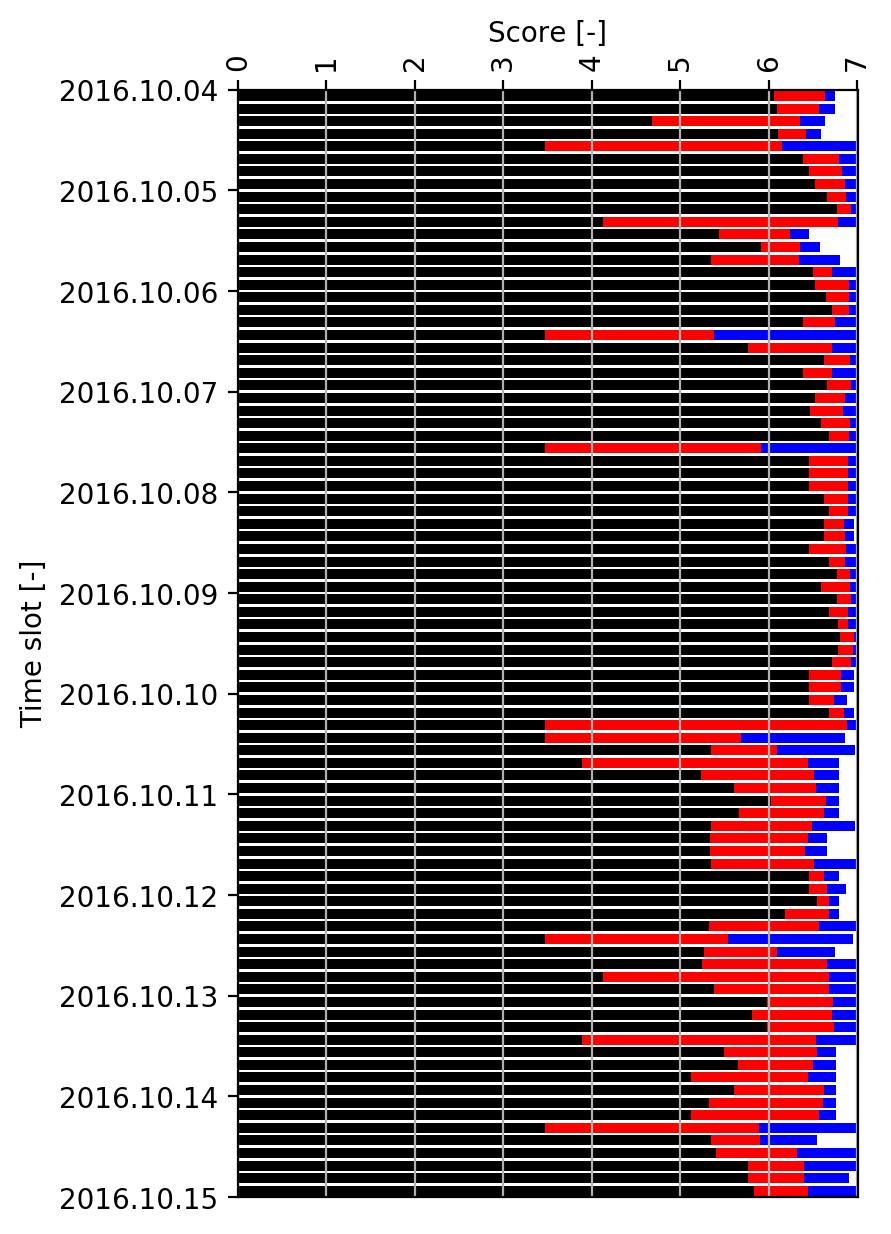

In [17]:
fig, ax = agg1.chartbar()

The next piece of code loops over the last 31 days of the data set in batch mode training and then in batch mode application. In the second loop, the summary statistics are updated iteratively. Note that we do not store the individual results, only the aggregated ones. This saves us some memory. Note also that we create a new *aggregate* object for two reasons: (a) otherwise we could add the previous results two times and (b) we want to use a different time window, 8 hours in this case:

In [18]:
iDayStart = 700
iDayEnd = 731
TimeWindow = 8
agg2 = aggregate(TimeWindow=TimeWindow,NumberOfSample=3600*TimeWindow)

print('Training')
for day in range(iDayStart,iDayEnd):
    filename = 'rowB_potential_day'+str(numpy.char.zfill(str(day+1),3))+'.csv'
    filepath = Path(strFolder+filename)
    if os.path.isfile(filepath):
        print('Train: '+filename)
        dfStrData =pandas.read_csv(filepath_or_buffer=filepath,delimiter  =';',header =0,dtype=str)
        CheckResult0 , DateTime =  CheckDT(DateTimeEntry=dfStrData['date_time'])
        CheckResult1 , Number   =  CheckNUM(NumberEntry=dfStrData['T1b'])
        
        CheckTYP(Number,Mode='Train')

print('Applying')
for day in range(iDayStart,iDayEnd):
    filename = 'rowB_potential_day'+str(numpy.char.zfill(str(day+1),3))+'.csv'
    filepath = Path(strFolder+filename)
    if os.path.isfile(filepath):
        print('Apply: '+filename)
        dfStrData =pandas.read_csv(filepath_or_buffer=filepath,delimiter  =';',header =0,dtype=str)
        CheckResult0 , DateTime =  CheckDT(DateTimeEntry=dfStrData['date_time'])
        CheckResult1 , Number   =  CheckNUM(NumberEntry=dfStrData['T1b'])
        Score, Density = CheckTYP(Number,Mode='Batch',NewSample=False)
    
        dfADD = pandas.DataFrame(columns=['DateTime','DateTimeCheck','Number','Score','Density'])
        dfADD['DateTime'] = DateTime
        dfADD['DateTimeCheck'] = CheckResult0
        dfADD['Number'] = Number
        dfADD['Score'] = Score
        dfADD['Density'] = Density
        
        agg2(dfADD)

Training
Train: rowB_potential_day701.csv
Train: rowB_potential_day702.csv
Train: rowB_potential_day703.csv
Train: rowB_potential_day704.csv
Train: rowB_potential_day705.csv
Train: rowB_potential_day706.csv
Train: rowB_potential_day707.csv
Train: rowB_potential_day708.csv
Train: rowB_potential_day709.csv
Train: rowB_potential_day710.csv
Train: rowB_potential_day711.csv
Train: rowB_potential_day712.csv
Train: rowB_potential_day713.csv
Train: rowB_potential_day714.csv
Train: rowB_potential_day715.csv
Train: rowB_potential_day716.csv
Train: rowB_potential_day717.csv
Train: rowB_potential_day718.csv
Train: rowB_potential_day719.csv
Train: rowB_potential_day720.csv
Train: rowB_potential_day721.csv
Train: rowB_potential_day722.csv
Train: rowB_potential_day723.csv
Train: rowB_potential_day724.csv
Train: rowB_potential_day725.csv
Train: rowB_potential_day726.csv
Train: rowB_potential_day728.csv
Train: rowB_potential_day729.csv
Train: rowB_potential_day730.csv
Train: rowB_potential_day731.csv
A

The next figure show the barplot for this period. One can see there is a significant gap in the data set at the end of September. This is due to a lack of data.

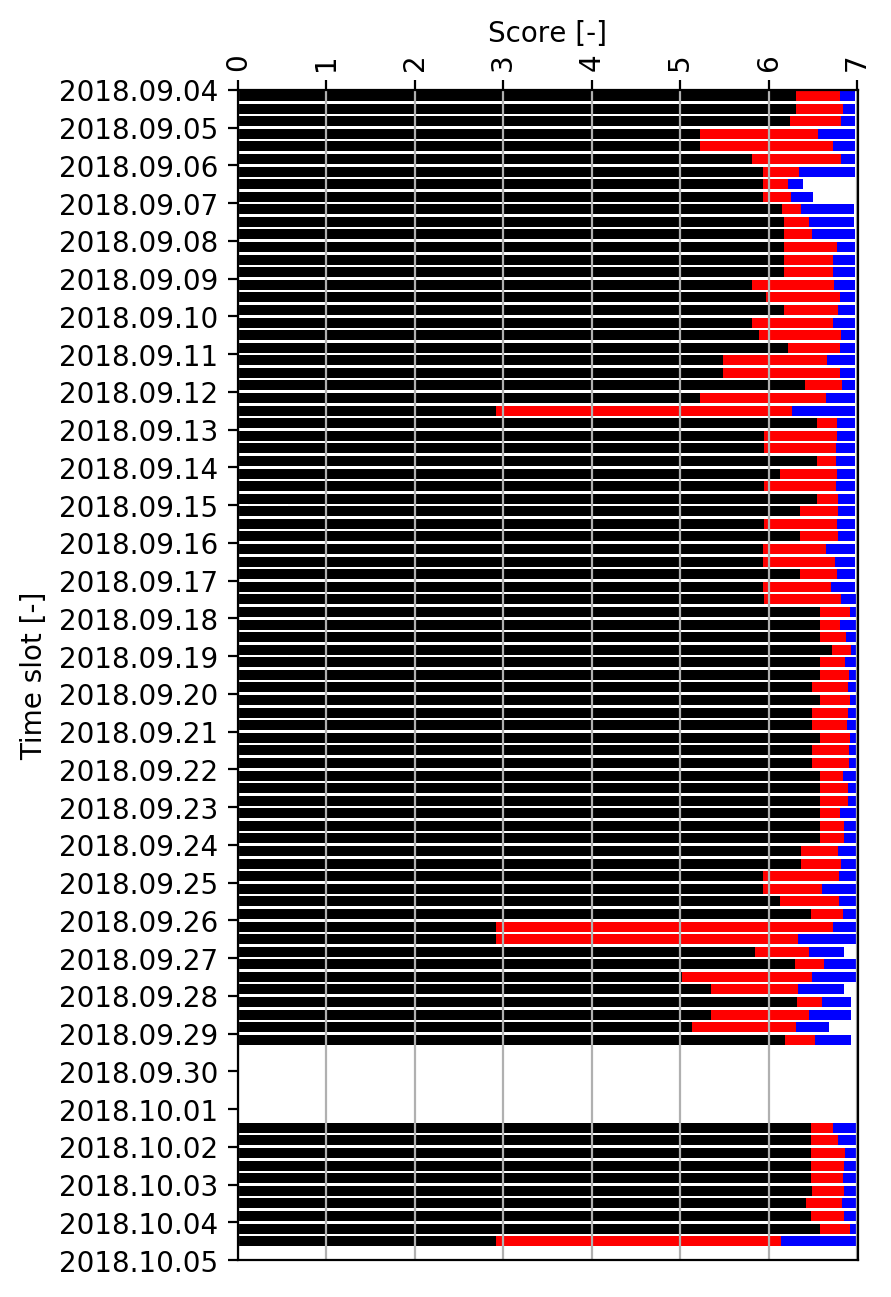

In [19]:
fig, ax = agg2.chartbar();

While the above plot is still manageable, it is does not scale to the complete data set, which contains about two years of data. A slightly better alternative is to produce a stem chart. The color scheme is the same as above. Here we can see that time windows without any data do not have any point in the plot.

..\basic\visual.py:92: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  ax.stem(x[s],y[s], linefmt=colour[s+shift]+'-', markerfmt=colour[s+shift]+'.', basefmt='k-')


<Figure size 1550x800 with 0 Axes>

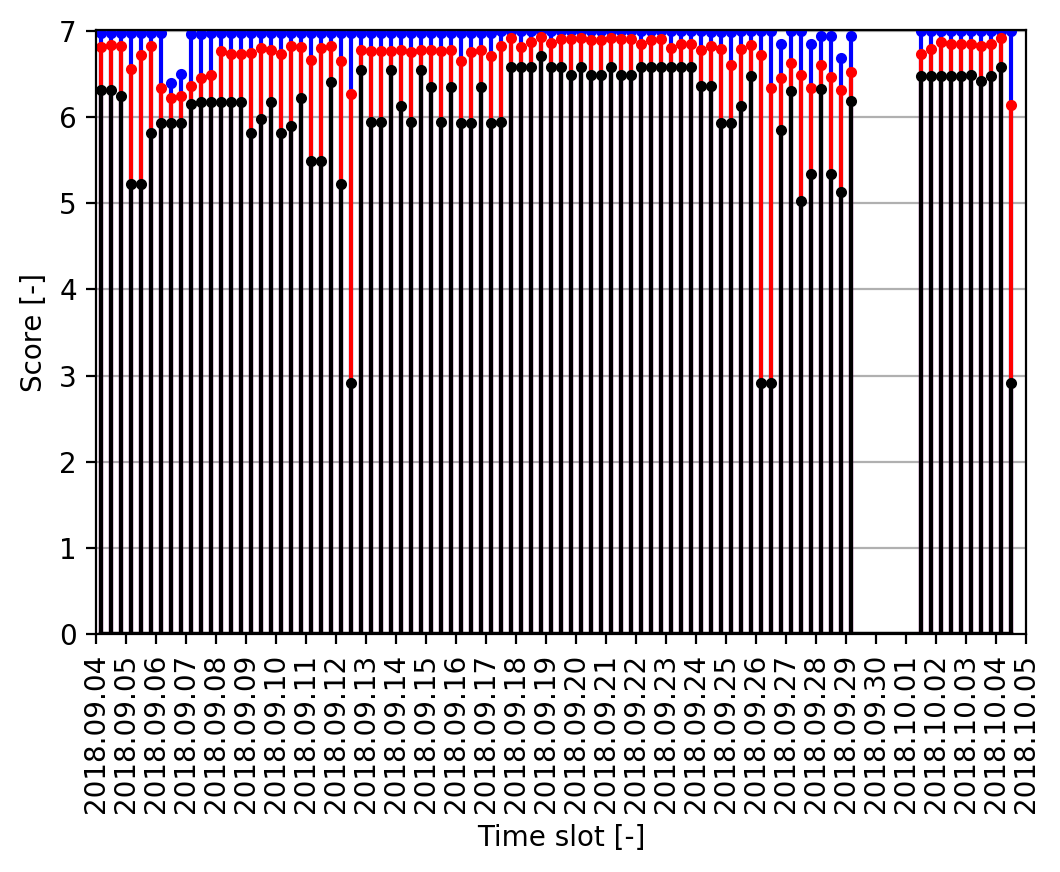

In [20]:
fig, ax = agg2.chartstem();

Even this plot will not scale very well for long time series. This is why a calendar heatmap is also useful. The next plot shows a heatmap of the minimum typicality score:

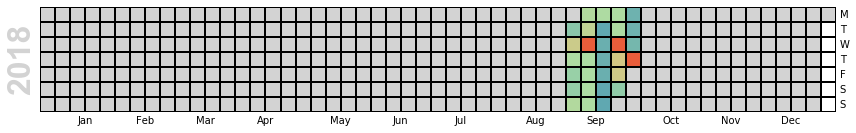

In [21]:
fig, ax = agg2.chartheat();

The next plots show the mean typicality score and the maximum typicality score:

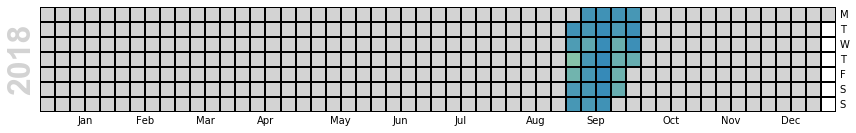

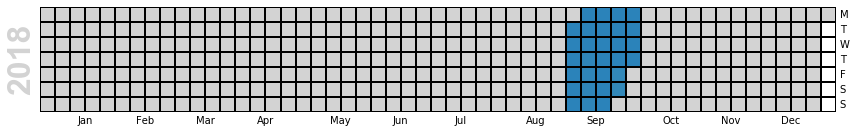

In [22]:
fig, ax = agg2.chartheat(mode='mean');
fig, ax = agg2.chartheat(mode='max');

The next piece of code creates a new aggregation object, and does the same as above with all files in the data set:

In [23]:
iDayStart = 0
iDayEnd = 731
TimeWindow = 24
agg3 = aggregate(TimeWindow=TimeWindow,NumberOfSample=3600*TimeWindow)

print('Training')
for day in range(iDayStart,iDayEnd):
    filename = 'rowB_potential_day'+str(numpy.char.zfill(str(day+1),3))+'.csv'
    filepath = Path(strFolder+filename)
    if os.path.isfile(filepath):
        print('Train: '+filename)
        dfStrData =pandas.read_csv(filepath_or_buffer=filepath,delimiter  =';',header =0,dtype=str)
        CheckResult0 , DateTime =  CheckDT(DateTimeEntry=dfStrData['date_time'])
        CheckResult1 , Number   = CheckNUM(NumberEntry=dfStrData['T1b'])
        CheckTYP(Number,Mode='Train')

print('Applying')
for day in range(iDayStart,iDayEnd):
    filename = 'rowB_potential_day'+str(numpy.char.zfill(str(day+1),3))+'.csv'
    filepath = Path(strFolder+filename)
    if os.path.isfile(filepath):
        print('Apply: '+filename)
        dfStrData =pandas.read_csv(filepath_or_buffer=filepath,delimiter  =';',header =0,dtype=str)
        CheckResult0 , DateTime =  CheckDT(DateTimeEntry=dfStrData['date_time'])
        CheckResult1 , Number   = CheckNUM(NumberEntry=dfStrData['T1b'])
        Score, Density = CheckTYP(Number,Mode='Batch',NewSample=False)
    
        dfADD = pandas.DataFrame(columns=['DateTime','DateTimeCheck','Number','Score','Density'])
        dfADD['DateTime'] = DateTime
        dfADD['DateTimeCheck'] = CheckResult0
        dfADD['Number'] = Number
        dfADD['Score'] = Score
        dfADD['Density'] = Density
        
        agg3(dfADD)

Training
Train: rowB_potential_day001.csv
Train: rowB_potential_day002.csv
Train: rowB_potential_day003.csv
Train: rowB_potential_day004.csv
Train: rowB_potential_day005.csv
Train: rowB_potential_day006.csv
Train: rowB_potential_day007.csv
Train: rowB_potential_day008.csv
Train: rowB_potential_day009.csv
Train: rowB_potential_day010.csv
Train: rowB_potential_day011.csv
Train: rowB_potential_day012.csv
Train: rowB_potential_day013.csv
Train: rowB_potential_day014.csv
Train: rowB_potential_day015.csv
Train: rowB_potential_day016.csv
Train: rowB_potential_day017.csv
Train: rowB_potential_day018.csv
Train: rowB_potential_day019.csv
Train: rowB_potential_day020.csv
Train: rowB_potential_day021.csv
Train: rowB_potential_day022.csv
Train: rowB_potential_day023.csv
Train: rowB_potential_day024.csv
Train: rowB_potential_day025.csv
Train: rowB_potential_day026.csv
Train: rowB_potential_day027.csv
Train: rowB_potential_day028.csv
Train: rowB_potential_day029.csv
Train: rowB_potential_day030.csv
T

Train: rowB_potential_day249.csv
Train: rowB_potential_day250.csv
Train: rowB_potential_day251.csv
Train: rowB_potential_day252.csv
Train: rowB_potential_day253.csv
Train: rowB_potential_day254.csv
Train: rowB_potential_day255.csv
Train: rowB_potential_day256.csv
Train: rowB_potential_day257.csv
Train: rowB_potential_day258.csv
Train: rowB_potential_day259.csv
Train: rowB_potential_day260.csv
Train: rowB_potential_day261.csv
Train: rowB_potential_day262.csv
Train: rowB_potential_day263.csv
Train: rowB_potential_day264.csv
Train: rowB_potential_day265.csv
Train: rowB_potential_day266.csv
Train: rowB_potential_day267.csv
Train: rowB_potential_day268.csv
Train: rowB_potential_day269.csv
Train: rowB_potential_day270.csv
Train: rowB_potential_day271.csv
Train: rowB_potential_day272.csv
Train: rowB_potential_day273.csv
Train: rowB_potential_day274.csv
Train: rowB_potential_day275.csv
Train: rowB_potential_day276.csv
Train: rowB_potential_day277.csv
Train: rowB_potential_day278.csv
Train: row

Train: rowB_potential_day498.csv
Train: rowB_potential_day499.csv
Train: rowB_potential_day500.csv
Train: rowB_potential_day501.csv
Train: rowB_potential_day502.csv
Train: rowB_potential_day503.csv
Train: rowB_potential_day504.csv
Train: rowB_potential_day505.csv
Train: rowB_potential_day506.csv
Train: rowB_potential_day507.csv
Train: rowB_potential_day508.csv
Train: rowB_potential_day509.csv
Train: rowB_potential_day510.csv
Train: rowB_potential_day511.csv
Train: rowB_potential_day512.csv
Train: rowB_potential_day513.csv
Train: rowB_potential_day514.csv
Train: rowB_potential_day515.csv
Train: rowB_potential_day516.csv
Train: rowB_potential_day517.csv
Train: rowB_potential_day518.csv
Train: rowB_potential_day519.csv
Train: rowB_potential_day520.csv
Train: rowB_potential_day521.csv
Train: rowB_potential_day522.csv
Train: rowB_potential_day523.csv
Train: rowB_potential_day524.csv
Train: rowB_potential_day525.csv
Train: rowB_potential_day526.csv
Train: rowB_potential_day527.csv
Train: row

Apply: rowB_potential_day016.csv
Apply: rowB_potential_day017.csv
Apply: rowB_potential_day018.csv
Apply: rowB_potential_day019.csv
Apply: rowB_potential_day020.csv
Apply: rowB_potential_day021.csv
Apply: rowB_potential_day022.csv
Apply: rowB_potential_day023.csv
Apply: rowB_potential_day024.csv
Apply: rowB_potential_day025.csv
Apply: rowB_potential_day026.csv
Apply: rowB_potential_day027.csv
Apply: rowB_potential_day028.csv
Apply: rowB_potential_day029.csv
Apply: rowB_potential_day030.csv
Apply: rowB_potential_day031.csv
Apply: rowB_potential_day032.csv
Apply: rowB_potential_day033.csv
Apply: rowB_potential_day034.csv
Apply: rowB_potential_day035.csv
Apply: rowB_potential_day036.csv
Apply: rowB_potential_day037.csv
Apply: rowB_potential_day038.csv
Apply: rowB_potential_day039.csv
Apply: rowB_potential_day040.csv
Apply: rowB_potential_day041.csv
Apply: rowB_potential_day042.csv
Apply: rowB_potential_day043.csv
Apply: rowB_potential_day044.csv
Apply: rowB_potential_day045.csv
Apply: row

Apply: rowB_potential_day265.csv
Apply: rowB_potential_day266.csv
Apply: rowB_potential_day267.csv
Apply: rowB_potential_day268.csv
Apply: rowB_potential_day269.csv
Apply: rowB_potential_day270.csv
Apply: rowB_potential_day271.csv
Apply: rowB_potential_day272.csv
Apply: rowB_potential_day273.csv
Apply: rowB_potential_day274.csv
Apply: rowB_potential_day275.csv
Apply: rowB_potential_day276.csv
Apply: rowB_potential_day277.csv
Apply: rowB_potential_day278.csv
Apply: rowB_potential_day279.csv
Apply: rowB_potential_day280.csv
Apply: rowB_potential_day281.csv
Apply: rowB_potential_day282.csv
Apply: rowB_potential_day283.csv
Apply: rowB_potential_day284.csv
Apply: rowB_potential_day285.csv
Apply: rowB_potential_day286.csv
Apply: rowB_potential_day287.csv
Apply: rowB_potential_day288.csv
Apply: rowB_potential_day289.csv
Apply: rowB_potential_day290.csv
Apply: rowB_potential_day291.csv
Apply: rowB_potential_day292.csv
Apply: rowB_potential_day293.csv
Apply: rowB_potential_day294.csv
Apply: row

Apply: rowB_potential_day514.csv
Apply: rowB_potential_day515.csv
Apply: rowB_potential_day516.csv
Apply: rowB_potential_day517.csv
Apply: rowB_potential_day518.csv
Apply: rowB_potential_day519.csv
Apply: rowB_potential_day520.csv
Apply: rowB_potential_day521.csv
Apply: rowB_potential_day522.csv
Apply: rowB_potential_day523.csv
Apply: rowB_potential_day524.csv
Apply: rowB_potential_day525.csv
Apply: rowB_potential_day526.csv
Apply: rowB_potential_day527.csv
Apply: rowB_potential_day528.csv
Apply: rowB_potential_day529.csv
Apply: rowB_potential_day530.csv
Apply: rowB_potential_day531.csv
Apply: rowB_potential_day532.csv
Apply: rowB_potential_day533.csv
Apply: rowB_potential_day534.csv
Apply: rowB_potential_day535.csv
Apply: rowB_potential_day536.csv
Apply: rowB_potential_day537.csv
Apply: rowB_potential_day538.csv
Apply: rowB_potential_day539.csv
Apply: rowB_potential_day540.csv
Apply: rowB_potential_day541.csv
Apply: rowB_potential_day542.csv
Apply: rowB_potential_day543.csv
Apply: row

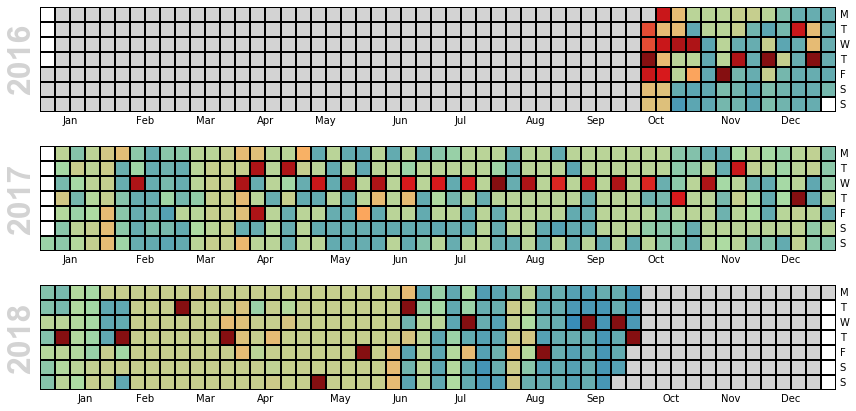

In [24]:
fig, ax = agg3.chartheat()

The graph clearly indicates that anomalous data are concentrated in a few days. 

# Take home message

The *AnomalyToolKit* enables to check the typicality of sensor signals manually or automatically. We imagine two straightforward use cases:

* Producing and checking one of the plots produced above on a regular basis and plan of suitable maintenance actions when considered necessary after inspection of the data.

* Setting a treshold for the minimum/mean/maximum typicality score in a given time slot and generate an automated alarm when the computed score falls below this number. This is then followed by a visual inspection of the signal and the planning of suitable maintenance actions.